# Prediction

Use the trained model to predict a new image.

In [1]:
from ultralytics import YOLO
from PIL import Image, ImageOps 
import PIL
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import numpy as np
import pandas as pd
from pathlib import Path
from utils import find_bounding_box

#model_path="./runs/segment/train2/weights/best.pt"
ROOT_DIR = Path(".")
model_path = ROOT_DIR / "datasets" / "results" / "200m_epochs-" / "weights" / "best.pt"
ASSETS_DIR = ROOT_DIR / "assets"

model = YOLO(model_path)

In [2]:
df_info = pd.read_excel("Tavolette_Sigle_unico.xlsx")

In [3]:
df_info

,TAV,INV (PT),DIAM (cm),RIB
0,1,777,48.0,0
1,1,300,29.0,0
2,1,301,47.0,0
3,1,818,33.0,1
4,1,30,28.0,1
...,...,...,...,...
200,46,593,19.0,0
201,46,831,18.0,1
202,46,354,23.0,1
203,47,469,38.0,0


Open the image file 

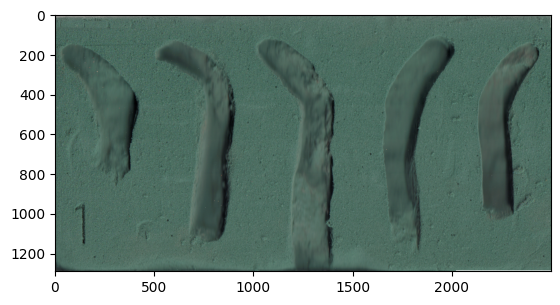

In [5]:
img = Image.open(r"C:\Users\larth\Desktop\Scannerizzazioni_tavolette_SALT\Scansioni\1.tif")
tab = 6
img_num = 3
pixel_cm_ration = 118.11

plt.imshow(img)

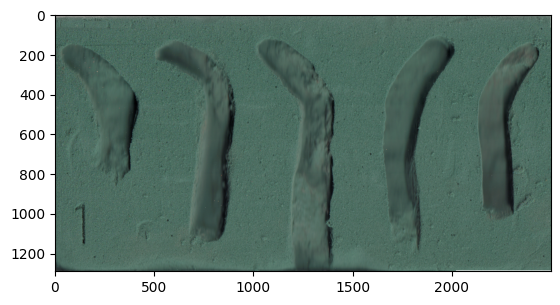

In [7]:
### rotate image
img = ImageOps.exif_transpose(img)
plt.imshow(img)

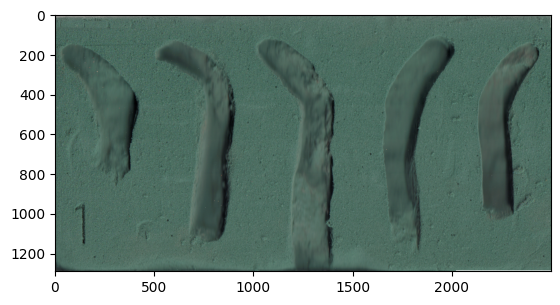

In [8]:
plt.imshow(img);

Run the model on the image

In [9]:
results = model.predict(img, save_crop=True, conf = 0.5, retina_masks = True)


0: 416x800 5 Profiles, 474.2ms
Speed: 6.6ms preprocess, 474.2ms inference, 1128.5ms postprocess per image at shape (1, 3, 416, 800)
Results saved to runs\segment\predict8


Visualize the prediction

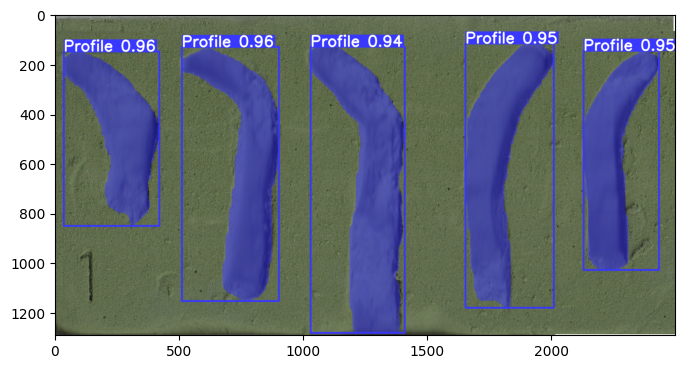

In [10]:
result_array = results[0].plot(masks=True)
plt.figure(figsize=(8, 8))
plt.imshow(result_array)
plt.show()

Detected bounding box are already saved, but we are also interested in the mask of the detected object.

In [11]:
extracted_masks = results[0].masks.data
masks_array = extracted_masks.cpu().numpy()

We have three objects in the image, so we will have three masks.

In [12]:
len(masks_array)

5

In [13]:
def find_bounding_box(mask):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

In [14]:
order = []

for i in range(len(masks_array)):
    num = find_bounding_box(masks_array[i])[2]
    order.append((i, num))


### sort the masks by the x coordinate of the bounding box
order.sort(key=lambda x: x[1])

In [15]:
df_info_tab = df_info.loc[df_info["TAV"] == tab]

In [16]:
df_info_tab

,TAV,INV (PT),DIAM (cm),RIB
23,6,1266,NaN,0
24,6,1285,28.0,0
25,6,1234,33.0,0
26,6,1271,28.0,0
27,6,1231,27.0,0


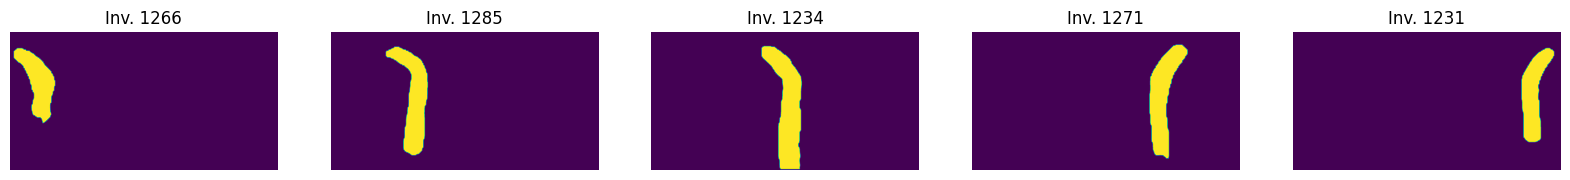

In [17]:
fig, ax = plt.subplots(1, len(masks_array), figsize=(20, 20))

for i in range(len(masks_array)):
    ax[i].imshow(masks_array[order[i][0]])
    ax[i].axis("off")
    ax[i].set_title(f"Inv. {df_info_tab.iloc[i]['INV (PT)'].astype(int)}")

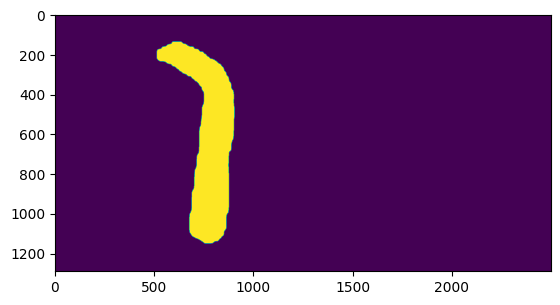

In [18]:
plt.imshow(masks_array[order[1][0]])

In [19]:
from PIL import Image, ImageFilter

In [20]:
from skimage.filters import median, gaussian
from skimage.morphology import disk

In [28]:
image = Image.fromarray(masks_array[order[1][0]].astype(np.uint8) * 255)

In [29]:
image = image.filter(ImageFilter.ModeFilter(size=50))

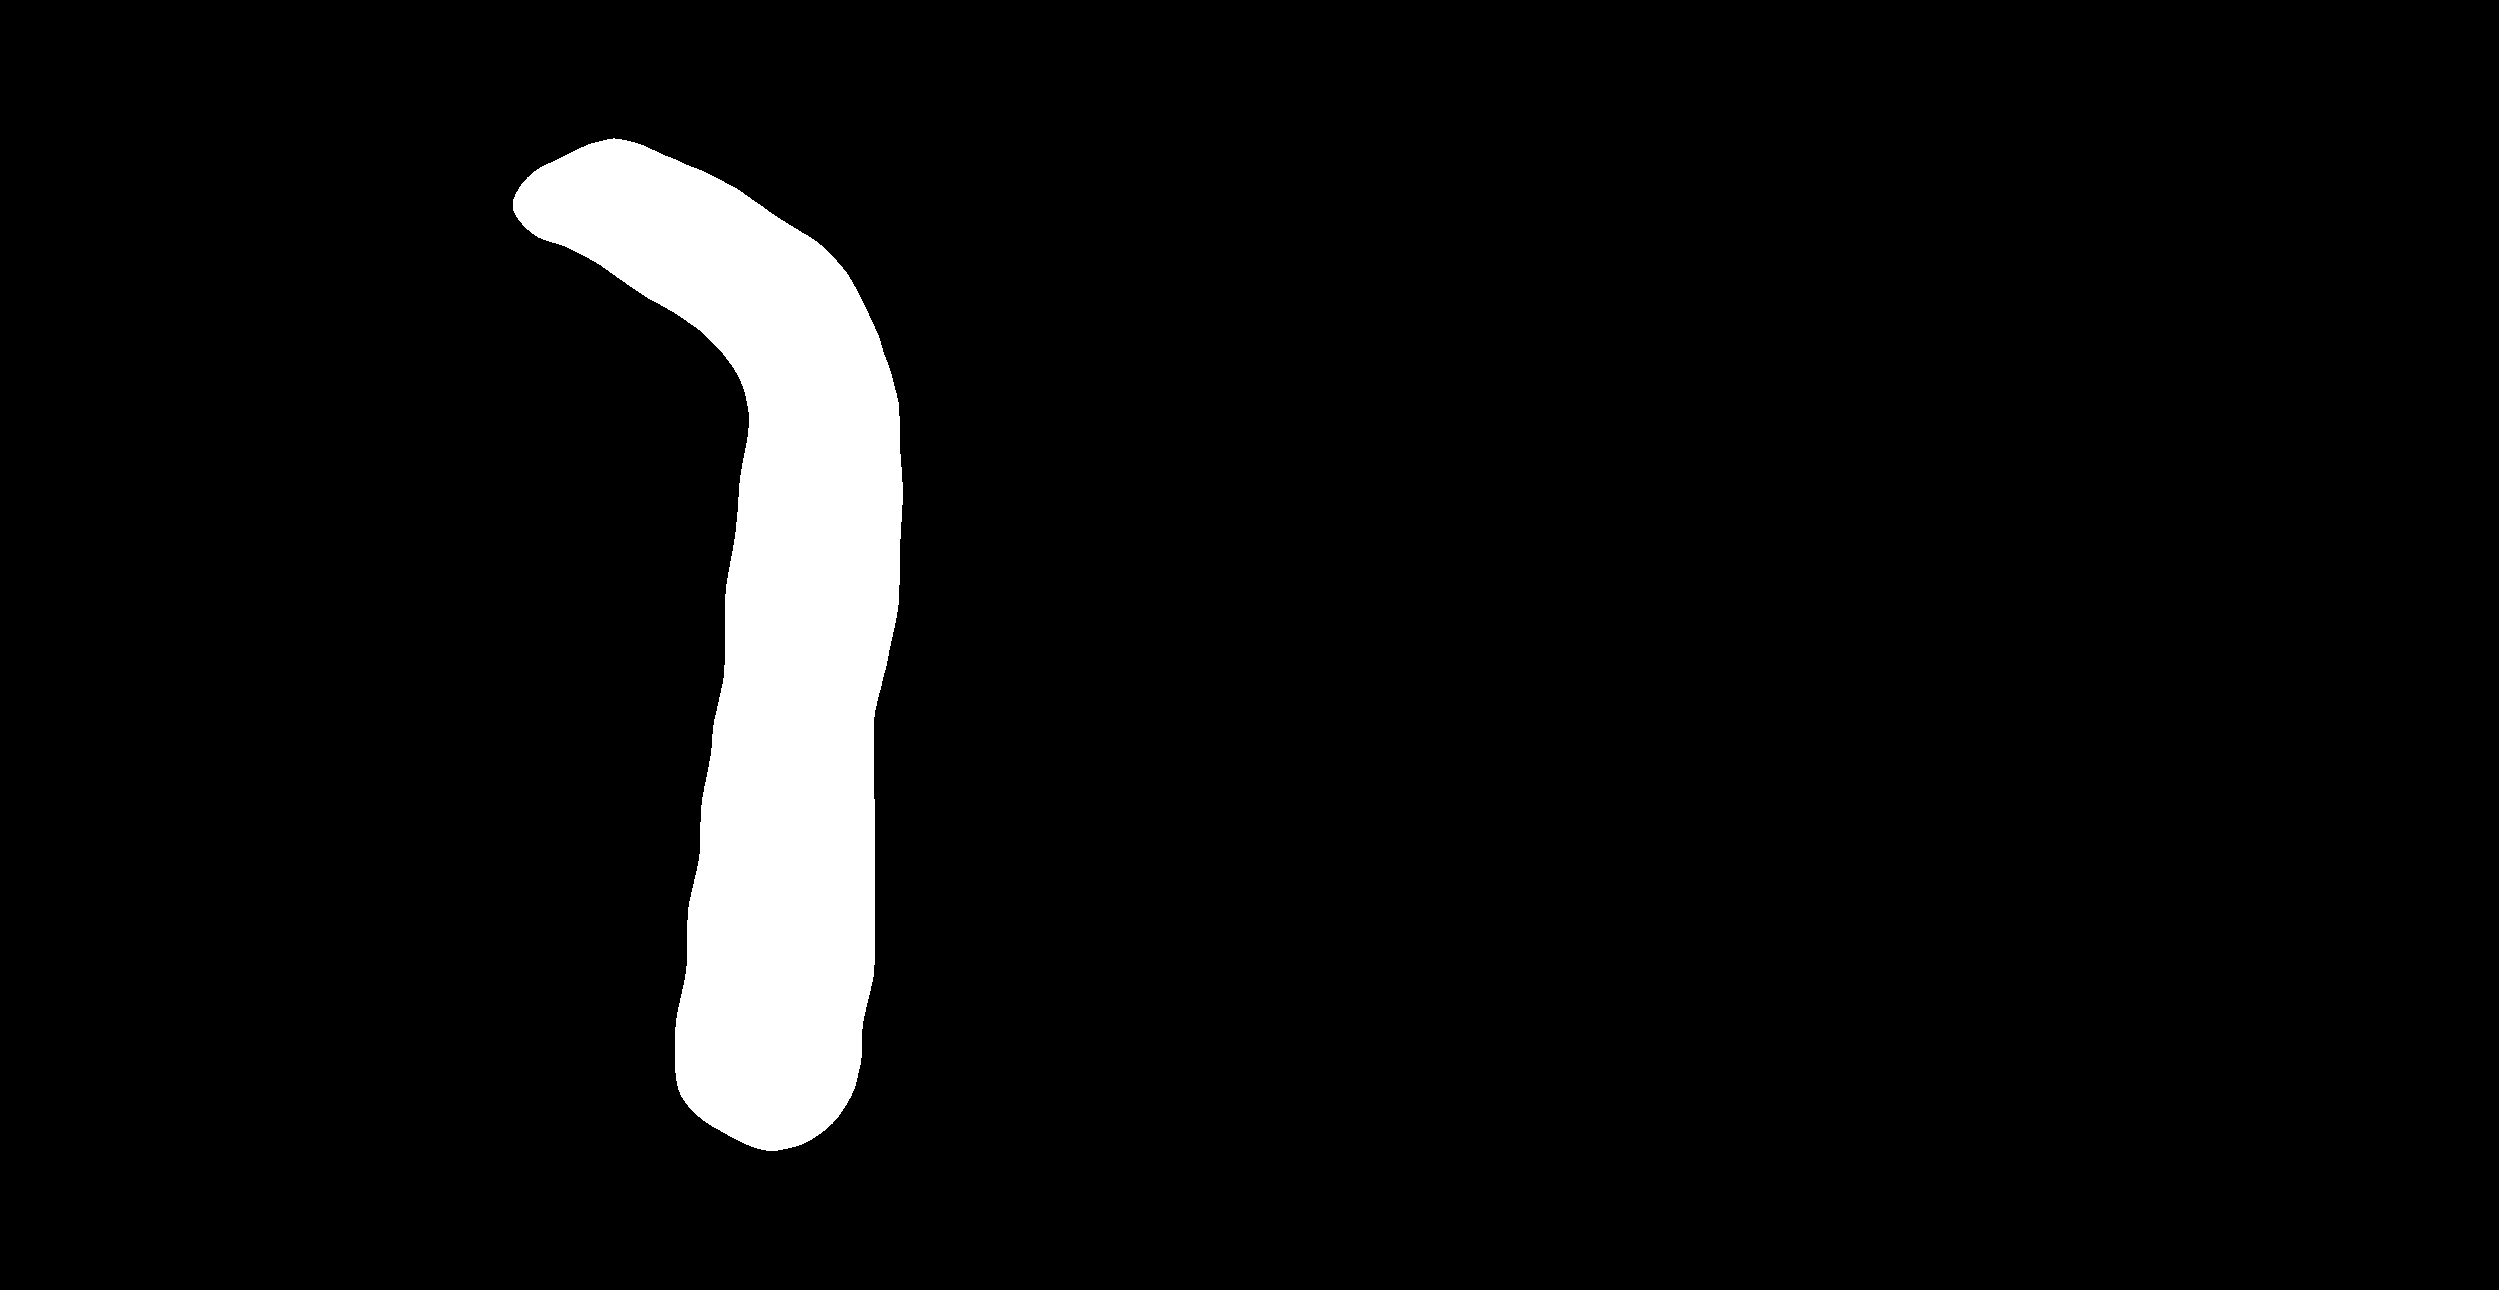

In [30]:
image

In [31]:
img = np.array(image)

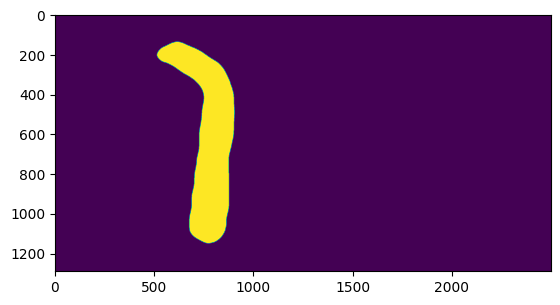

In [32]:
plt.imshow(img)

In [33]:
# get the bounding box of the mask
rmin, rmax, cmin, cmax = find_bounding_box(img)
## extract the mask
mask = img[rmin:rmax, cmin:cmax]

mask = mask / 255

In [34]:
mask.max()

1.0

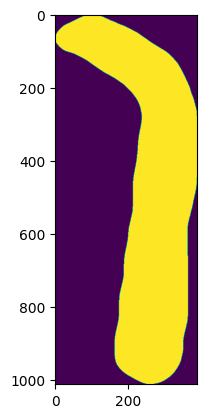

In [35]:
plt.imshow(mask)

In [36]:
### for each row, get the first and pixel of the mask
first_pixel = []
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i, j] == 1:
            first_pixel.append((i, j))
            break

In [37]:
first_pixel[0][1]

100

In [38]:
import seaborn as sns

In [77]:
len(np.array(first_pixel)[:, 1])

1012

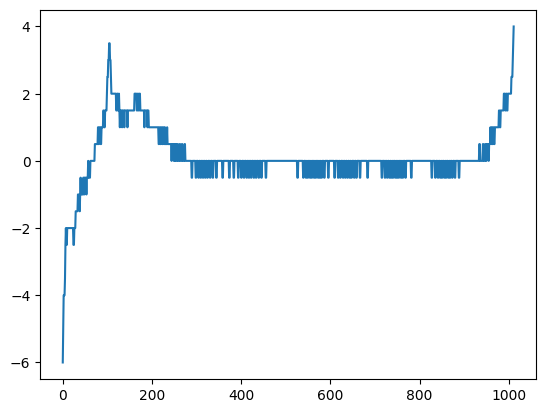

In [47]:
plt.plot(np.gradient(np.array(first_pixel)[:, 1], axis=0))

In [78]:
gradients = np.gradient(np.array(first_pixel)[:, 1], axis=0)

In [79]:
len(gradients)

1012

In [80]:
zero_gradient_mask = gradients == 0

In [81]:
len(zero_gradient_mask)

1012

In [82]:
zero_gradient_mask

array([False, False, False, ..., False, False, False])

In [84]:
### take the index of the last true value
last_zero_gradient = np.where(zero_gradient_mask)[0][-1]

In [86]:
last_zero_gradient

955

In [72]:
diam_pix = df_info_tab.iloc[img_num]["DIAM (cm)"] * pixel_cm_ration

In [73]:
diam_pix

3307.08

In [90]:
### create a mask with the first pixel of each row
first_pixel_mask = np.zeros_like(mask)
for i, j in first_pixel:
    if i < last_zero_gradient:
        first_pixel_mask[i, j] = 1
    else:
        first_pixel_mask[i, j] = 0

In [91]:
first_pixel_mask = binary_dilation(first_pixel_mask, iterations=5)

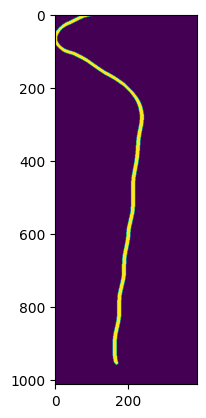

In [92]:
plt.imshow(first_pixel_mask)

In [93]:
diam_pix + first_pixel[0][1]*2

3507.08

In [94]:
### create an empty array with the same shape of the mask

empty_mask = np.zeros((mask.shape[0],int(diam_pix + first_pixel[0][1]*2)))

In [95]:
empty_mask.shape

(1012, 3507)

In [96]:
empty_mask[:, :mask.shape[1]] = mask
empty_mask_flipped = np.flip(empty_mask, axis=1)
empty_mask_flipped[:, :mask.shape[1]] = first_pixel_mask

empty_mask = np.flip(empty_mask_flipped, axis=1)

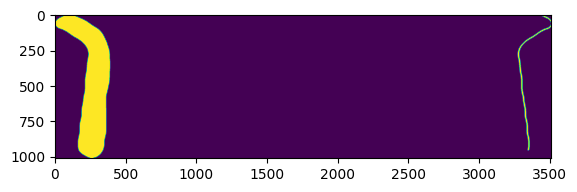

In [97]:
plt.imshow(empty_mask)

In [98]:
empty_mask[0:5, :] = 1

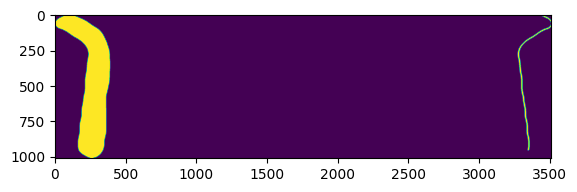

In [99]:
plt.imshow(empty_mask)

In [100]:
empty_mask = np.flip(empty_mask, axis=1)

for i, j in first_pixel:
    empty_mask[i, :j] = 0

empty_mask = np.flip(empty_mask, axis=1)

for i, j in first_pixel:
    empty_mask[i, :j] = 0


In [101]:
first_pixel[0]

(0, 100)

In [102]:
empty_mask[:, empty_mask.shape[1] // 2: empty_mask.shape[1] // 2+5] = 1

In [103]:
prova = np.pad(empty_mask, ((100, 100), (100, 100)), mode="constant", constant_values=0)

In [104]:
df_info_tab

,TAV,INV (PT),DIAM (cm),RIB
23,6,1266,NaN,0
24,6,1285,28.0,0
25,6,1234,33.0,0
26,6,1271,28.0,0
27,6,1231,27.0,0


Text(0, 1636.2, 'DIAM: 28.0')

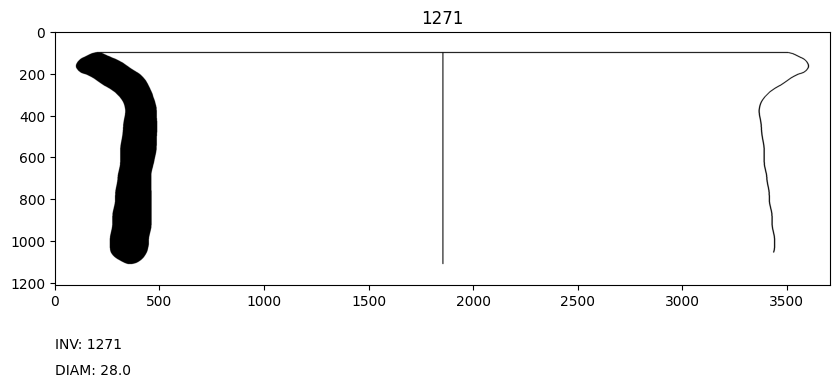

In [105]:
fig, ax = plt.subplots(1, figsize=(10, 10))

ax.imshow(1-prova, cmap="gray")

ax.set_title(f"{df_info_tab.iloc[img_num]['INV (PT)'].astype(int)}")

## add text outside the image
ax.text(0, prova.shape[0]*1.25, f"INV: {df_info_tab.iloc[img_num]['INV (PT)'].astype(int)}", fontsize=10)
ax.text(0, prova.shape[0]*1.35, f"DIAM: {df_info_tab.iloc[img_num]['DIAM (cm)']}", fontsize=10)